In [1]:
# Get Connector JAR name
import glob
import os

files = glob.glob("/spark-connector/connector/target/scala-2.12/spark-vertica-connector-assembly-*")
os.environ["CONNECTOR_JAR"] = files[0]
print(os.environ["CONNECTOR_JAR"])

/spark-connector/connector/target/scala-2.12/spark-vertica-connector-assembly-3.3.5.jar


In [2]:
# Create the Spark session and context
from pyspark.sql import SparkSession

spark = (SparkSession.builder
    .config("spark.master", "spark://spark:7077")
    .config("spark.driver.memory", "2G")
    .config("spark.executor.memory", "1G")
    .config("spark.jars", os.environ["CONNECTOR_JAR"])
    .getOrCreate())
sc = spark.sparkContext

In [3]:
# Display the context information
print(sc.version)
print(sc.master)
display(sc.getConf().getAll())

3.3.1
spark://spark:7077


[('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.driver.host', 'bd6dcbac6470'),
 ('spark.driver.memory', '2G'),
 ('spark.master', 'spark://spark:7077'),
 ('spark.repl.local.jars',
  'file:///spark-connector/connector/target/scala-2.12/spark-vertica-connector-assembly-3.3.5

In [15]:
# Load some example data from a CSV file into a dataframe and show some if its contents
df = spark.read.options(header="true", inferschema="true").csv("/spark-connector/examples/jupyter/data/faithful.csv")
df.printSchema()
df.show()

# Write the data into a table in Vertica
df.write.mode("overwrite").format("com.vertica.spark.datasource.VerticaSource").options(
    host="vertica",
    user="dbadmin",
    password="",
    db="docker",
    table="LR_Example",
    staging_fs_url="webhdfs://hdfs:50070/linearregression").save()

root
 |-- id: integer (nullable = true)
 |-- eruptions: double (nullable = true)
 |-- waiting: integer (nullable = true)

+---+---------+-------+
| id|eruptions|waiting|
+---+---------+-------+
|  1|      3.6|     79|
|  2|      1.8|     54|
|  3|    3.333|     74|
|  4|    2.283|     62|
|  5|    4.533|     85|
|  6|    2.883|     55|
|  7|      4.7|     88|
|  8|      3.6|     85|
|  9|     1.95|     51|
| 10|     4.35|     85|
| 11|    1.833|     54|
| 12|    3.917|     84|
| 13|      4.2|     78|
| 14|     1.75|     47|
| 15|      4.7|     83|
| 16|    2.167|     52|
| 17|     1.75|     62|
| 18|      4.8|     84|
| 19|      1.6|     52|
| 20|     4.25|     79|
+---+---------+-------+
only showing top 20 rows



In [16]:
# Import Spark's ML Regression tool
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

# Read our data from Vertica into a Spark dataframe
df = spark.read.load(format="com.vertica.spark.datasource.VerticaSource",
    host="vertica",
    user="dbadmin",
    password="",
    db="docker",
    table="LR_Example",
    staging_fs_url="webhdfs://hdfs:50070/linearregression")

# Spark's Linear Regression tool requires an array of the features we want to use. Since we only have one in this case, we add "waiting"
featureassembler = VectorAssembler(inputCols = ["waiting"], outputCol = "features")

# Show our new table with a features column added
output = featureassembler.transform(df)
output.show()

# Create our model using the features to predict eruption duration
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, featuresCol="features", labelCol="eruptions")
lr = lr.fit(output)

# Show our new table with the predictions
pred_results = lr.evaluate(output)
pred_results.predictions.show()

+---+---------+-------+--------+
| id|eruptions|waiting|features|
+---+---------+-------+--------+
|  1|      3.6|     79|  [79.0]|
|  2|      1.8|     54|  [54.0]|
|  3|    3.333|     74|  [74.0]|
|  4|    2.283|     62|  [62.0]|
|  5|    4.533|     85|  [85.0]|
|  6|    2.883|     55|  [55.0]|
|  7|      4.7|     88|  [88.0]|
|  8|      3.6|     85|  [85.0]|
|  9|     1.95|     51|  [51.0]|
| 10|     4.35|     85|  [85.0]|
| 11|    1.833|     54|  [54.0]|
| 12|    3.917|     84|  [84.0]|
| 13|      4.2|     78|  [78.0]|
| 14|     1.75|     47|  [47.0]|
| 15|      4.7|     83|  [83.0]|
| 16|    2.167|     52|  [52.0]|
| 17|     1.75|     62|  [62.0]|
| 18|      4.8|     84|  [84.0]|
| 19|      1.6|     52|  [52.0]|
| 20|     4.25|     79|  [79.0]|
+---+---------+-------+--------+
only showing top 20 rows

+---+---------+-------+--------+------------------+
| id|eruptions|waiting|features|        prediction|
+---+---------+-------+--------+------------------+
|  1|      3.6|     79|  [

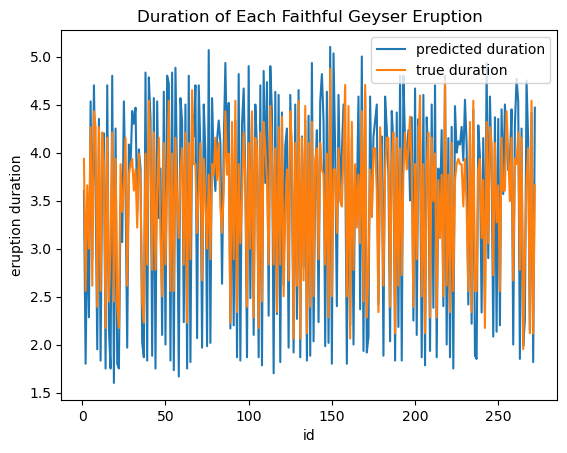

In [17]:
# Some graphs to visualize this data
import matplotlib.pyplot as plt

x = output.select("id").collect()
y2 = pred_results.predictions.select("prediction").collect()
y1 = pred_results.predictions.select("eruptions").collect()

plt.plot(x, y1, label = "predicted duration")
plt.plot(x, y2, label = "true duration")

plt.xlabel("id")
plt.ylabel("eruption duration")

plt.title("Duration of Each Faithful Geyser Eruption")
plt.legend()

plt.show()